# Model evaluation: BERT (multitasking)

---

## Table of Contents

1. [Imports](#imports)
2. [Model loading](#model-loading)
3. [Data loading and tokenization](#data-loading-and-tokenization)
4. [Evaluation](#evaluation)
5. [Report](#report)

# Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.metrics import classification_report, confusion_matrix
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Model loading

In [2]:
class MultitaskBERT(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased'):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        hidden_size = self.bert.config.hidden_size
        self.classifier_sentiment = nn.Linear(hidden_size, 3)
        self.classifier_emotion = nn.Linear(hidden_size, 6)

    def forward(self, input_ids, attention_mask, task):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.pooler_output
        
        if task == "sentiment":
            return self.classifier_sentiment(pooled)
        else:
            return self.classifier_emotion(pooled)

In [3]:
device = 'cuda'

tokenizer = BertTokenizer.from_pretrained('./bert_multitasking_model')
model = MultitaskBERT().to(device)
model.load_state_dict(torch.load('./bert_multitasking_model/bert_multitasking_model.pth', map_location=device))

C:\Users\Olga\AppData\Local\Temp\ipykernel_3064\968149905.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./bert_multitasking_model/ber

<All keys matched successfully>

# Data loading and tokenization

In [4]:
base_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..'))
df_sentiment = pd.read_csv(os.path.join(base_dir, 'test_sentiment.csv'))
df_emotion = pd.read_csv(os.path.join(base_dir, 'test_emotion.csv'))

In [5]:
class LabeledDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.texts = data['text']
        self.labels = data['label']
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [6]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    dataset = LabeledDataset(data, tokenizer, max_len)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
loader_sentiment = DataLoader(LabeledDataset(df_sentiment, tokenizer, 256), batch_size=16)
loader_emotion = DataLoader(LabeledDataset(df_emotion, tokenizer, 256), batch_size=16)

# Evaluation

In [8]:
def evaluate(task_name, model, dataloader, class_names):
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask, task=task_name)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Classification Report ({task_name}):")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    labels_fmt = np.array([["{0:.2f}%".format(val) for val in row] for row in cm_percent])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_percent, annot=labels_fmt, fmt="", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predykcja")
    plt.ylabel("Rzeczywista klasa")
    plt.tight_layout()
    plt.savefig(f'cf_mat_bert_multi__{task_name}.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    f1_scores = [report[label]['f1-score'] for label in class_names]
    plt.figure(figsize=(5, 2.5))
    bars = plt.bar(class_names, f1_scores, color=['red', 'blue', 'green'] if task_name == "sentiment" else ['gray', 'green', 'pink', 'red', 'yellow', 'blue'])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.09, f"{yval:.2f}", ha='center')
    plt.ylim(0, 1)
    plt.ylabel("F1-score")
    plt.xlabel('Klasa')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.savefig(f"f1_bar_bert_multi__{task_name}.png", dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# Report

Classification Report (sentiment):
              precision    recall  f1-score   support

   Negatywny       0.65      0.80      0.72      3391
   Neutralny       0.74      0.63      0.68      6322
   Pozytywny       0.78      0.80      0.79      5087

    accuracy                           0.73     14800
   macro avg       0.72      0.74      0.73     14800
weighted avg       0.73      0.73      0.73     14800



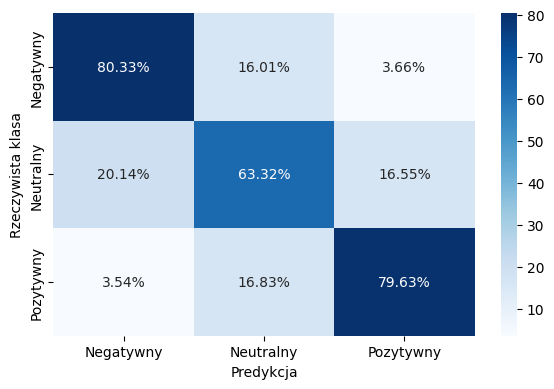

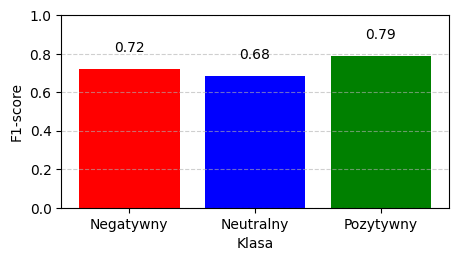

In [9]:
sentiment_classes = ['Negatywny', 'Neutralny', 'Pozytywny']
emotion_classes = ['Smutek', 'Radość', 'Miłość', 'Złość', 'Strach', 'Zaskoczenie']

evaluate("sentiment", model, loader_sentiment, sentiment_classes)

Classification Report (emotion):
              precision    recall  f1-score   support

      Smutek       0.98      0.95      0.97      2500
      Radość       0.99      0.91      0.95      2500
      Miłość       0.93      1.00      0.96      2500
       Złość       0.92      0.98      0.95      2500
      Strach       0.97      0.85      0.90      2500
 Zaskoczenie       0.90      1.00      0.95      2206

    accuracy                           0.95     14706
   macro avg       0.95      0.95      0.95     14706
weighted avg       0.95      0.95      0.95     14706



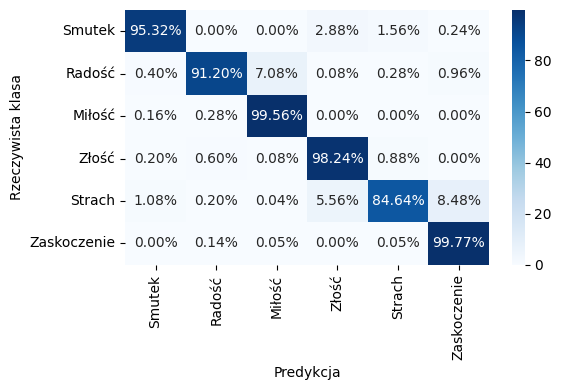

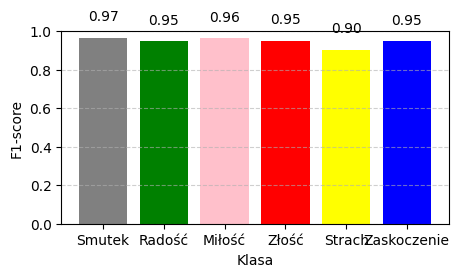

In [10]:
evaluate("emotion", model, loader_emotion, emotion_classes)